# Практика №1

Первое практическое занятие мы начнем с реализации dynamic time warping (DTW) алгоритм на основе token passing algorithm (TPA).

У нас имеется несколько эталонов (различные вариации произнесения слов YES и NO) и пара записей (также YES и NO). С помощью алгоритма DTW нам будет необходимо определить, на какой из эталонов больше всего похожа каждая запись. Данные wav файлы взяты из открытой базы данных Google Speech Commands Dataset (https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html).

### Bootstrap

In [1]:
!gdown --id "1VNi62ZxZA7rgMKsvECDGZdl3WQJcBKRb"

Downloading...
From: https://drive.google.com/uc?id=1VNi62ZxZA7rgMKsvECDGZdl3WQJcBKRb
To: /content/lab1.zip
100% 1.11M/1.11M [00:00<00:00, 17.6MB/s]


In [2]:
!unzip -q lab1.zip
!rm -rf lab1.zip sample_data
%cd lab1

/content/lab1


In [3]:
import os
import time

import librosa, librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm.notebook import tqdm
import IPython.display as ipd

In [4]:
plt.rcParams["figure.figsize"] = (15.0, 5.0)
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

Рассмотрим на примере один из эталонов:

In [5]:
wav_example = "data/yes_no/etalons/yes_004ae714_nohash_0.wav"

# Read wav-file.
# Here sr=None to preserve the native sampling rate.
x, sr = librosa.load(wav_example, sr=None)

print(f"Number of samples: {len(x)}.")
print(f"Sampling rate: {sr} Hz.")
# ~ librosa.get_duration(x, sr):
print(f"Duration: {len(x) / sr:.2f} s.")

# Playback:
ipd.Audio(x, rate=sr)

Number of samples: 16000.
Sampling rate: 16000 Hz.
Duration: 1.00 s.


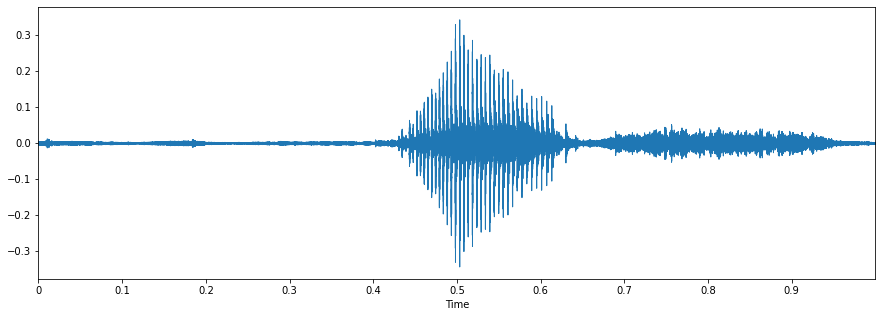

In [6]:
# Time representation of the signal:
librosa.display.waveplot(x, sr=sr);

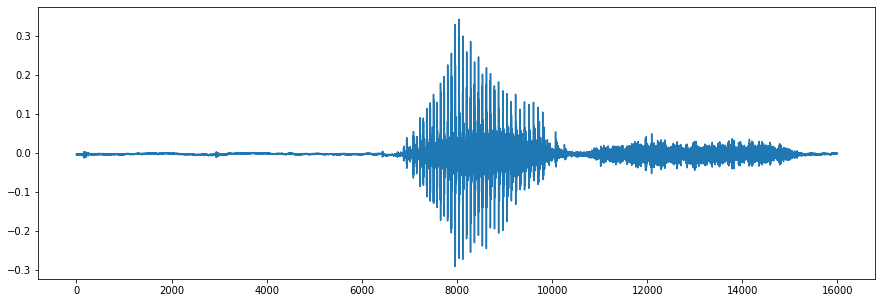

In [7]:
plt.plot(x);

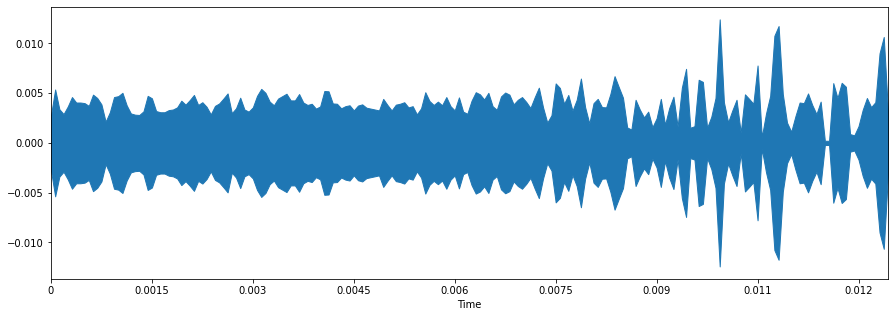

In [8]:
librosa.display.waveplot(x[:200], sr=sr);

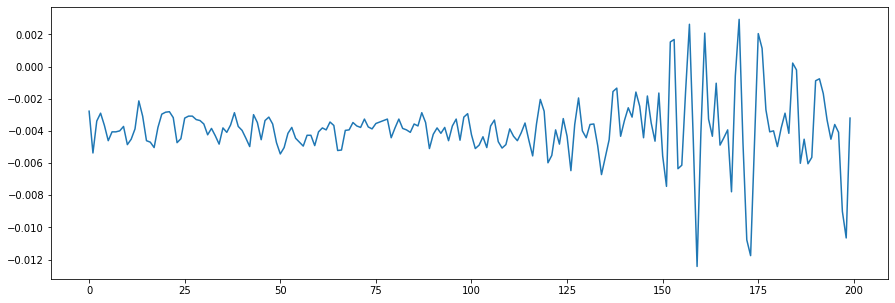

In [9]:
plt.plot(x[:200]);

The view is different from the one that can be plotted with `matplotlib` in two aspects:
* `librosa` transforms signal samples into seconds with respect to sampling rate ($t = k / sr$, where $k$ is the sample number), whereas `matplotlib` takes plain sample numbers as units;
* for a monophonic signal (like the one that we have) `librosa` plots a curve filled between `[-abs(y), abs(y)]` (symmetric with respect to Y-axis), whereas `matplotlib`'s plot is asymmetric.

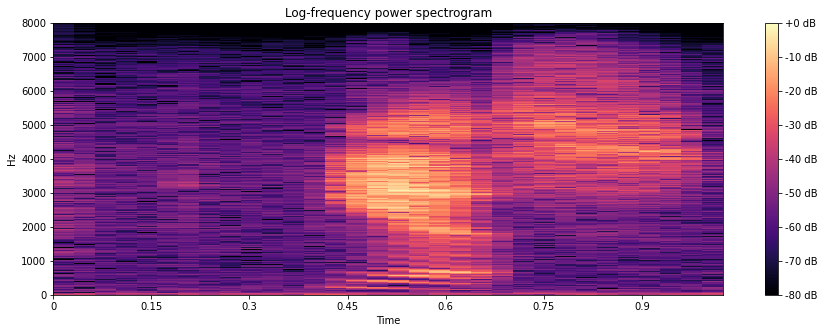

In [10]:
# Spectrogram:
D = librosa.amplitude_to_db(np.abs(librosa.stft(x)), ref=np.max)
librosa.display.specshow(D, sr=sr, y_axis="hz", x_axis="time")
plt.colorbar(format="%+2.0f dB")
plt.title("Log-frequency power spectrogram");

Теперь посчитаем речевые признаки нашего эталона.
Для начала будем работать с 13-размерными MFCC признаками.

In [11]:
# n_fft = 25 ms        -- длина кадра
# hop_length = 10 ms   -- длина шага
# Тогда в отсчётах получаем следующее:
n_fft = int(sr * 0.025)
hop_length = int(sr * 0.01)

mfcc = librosa.feature.mfcc(x, sr=sr, n_mfcc=13, n_fft=n_fft,
                            hop_length=hop_length)

print(mfcc.shape)
print(mfcc[:, 0])  # вектор признаков нулевого кадра

(13, 101)
[-668.8059      -1.2019875    4.53354     35.322647     9.764597
    9.849829    10.895137    15.9373       4.3746996   11.116629
    4.147642     1.4780188   -5.5366154]


Теперь приступим к описанию самого DTW алгоритма.
Для начала нам потребуется создать граф, ветвями которого будут наши эталоны, с которыми мы и будем сравнивать записи. Все ветви графа будут состоять из узлов типа `State`. Каждый такой узел представляет собой описание отдельного кадра эталона. Таким образом число узлов в ветви равно числу кадров в эталоне.

На данном этапе узлы в графе будут иметь переходы только в себя и следующий узел. Нулевой узел является корневым и имеет переходы в начальные узлы каждой ветви. Финальный узел каждой ветви имеет переход только в себя. Схема такого графа представлена ниже:

![](https://drive.google.com/uc?export=view&id=1PQwZSf9EFEZUWQt9dmOifpyqCM6uuCRM)

Здесь мы имеем два эталона слов YES и NO длиной 4 и 3 кадра соответственно.

In [12]:
class State:
    def __init__(self, feats, index):
        # feats: node feature vector
        # is_final: whether the node is final in the word
        # word: etalon word (only present for the final node)
        # best_token: token with the least distance in the node
        # current_word: current etalon word
        # next_states: the list of next nodes
        # index: node index
        self.feats = feats
        self.is_final = False
        self.word = None
        self.best_token = None
        self.current_word = None
        self.next_states = []
        self.index = index


def load_graph(etalons_dict, enable_skips=False):
    start_state = State(None, 0)
    graph = [start_state,]
    state_index = 1
    for word in etalons_dict.keys():
        previous_state = start_state
        for feats_frame in etalons_dict[word]:
            state = State(feats_frame, state_index)
            # Etalon word will now be stored in each node:
            state.current_word = word
            # Add loop:
            state.next_states.append(state)
            previous_state.next_states.append(state)
            previous_state = state
            #-----------------------------TODO №2------------------------------
            # Добавьте переходы через один и через два узла
            # (hint): добавлять переходы проще задним числом
            if enable_skips:
                if state in graph[state.index - 1].next_states \
                    and graph[state.index - 1] in graph[state.index - 2].next_states \
                    and state.index - 2 > 0:
                    graph[state.index - 2].next_states.append(state)
                    if graph[state.index - 2] in graph[state.index - 3].next_states \
                        and state.index - 3 > 0:
                        graph[state.index - 3].next_states.append(state)
            #------------------------------------------------------------------
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph


def print_graph(graph):
    if not os.path.exists("exp"):
        os.mkdir("exp")
    with open("exp/graph.txt", 'w') as fn:
        np.set_printoptions(formatter={"float": "{: 0.1f}".format})
        for state in graph:
            next_state_indexes = [s.index for s in state.next_states]
            fn.write(
                "State: index={} word={} is_final={} " \
                "next_state_indexes={} ftr={} \n".format(
                    state.index, state.word, state.is_final,
                    next_state_indexes, state.feats
                )
            )
    print("*** See exp/graph.txt ***")

Подготовка наших эталонов и записей для распознавания:

In [13]:
def load_data_dict(dir_path):
    data_dict = {}
    for wav_name in os.listdir(dir_path):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(x, sr=sr, n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        data_dict[wav_name] = mfcc.T

    return data_dict

In [14]:
etalons_dir = "data/yes_no/etalons"
records_dir = "data/yes_no/records"

etalons_data_dict = load_data_dict(etalons_dir)
records_data_dict = load_data_dict(records_dir)

In [15]:
graph = load_graph(etalons_data_dict)
print_graph(graph)

*** See exp/graph.txt ***


Далее идет описание класса Token и самого алгоритма TPA:

- Алгоритм TPA двигается последовательно по кадрам записи, на каждом кадре берёт множество токенов от предыдущего кадра и порождает множество токенов для текущего кадра.
- Один токен – это вещь, олицетворяющая собой один из возможных вариантов разметки (соотнесения кадров записи кадрам эталона), заканчивающаяся на данном кадре. По токену можно понять, какую суммарную дистанцию набрал данный токен (то есть то, насколько он хорош), в каком узле графа эталонов он находится (чтобы от него можно было породить токен для следующего кадра) и на ветке какого слова он находится на данный момент.
- На некотором кадре всё множество токенов описывает все возможные разметки, которые можно получить к данному кадру. После обработки последнего кадра мы просто переберём все финальные токены (разметки) и выберем лучший (тот, который имеет минимальное суммарное расстояние от записи до эталона).
- Финальные токены – это токены, которым соответствует законченная разметка (то есть та, в которой после финального кадра мы оказались в финальном узле графа). Остальные токены могут рассматриваться как бракованные.

Получается, что TPA (в том виде, в котором он тут описан) – это удобная форма записи полного перебора всех возможных разметок.

### Проблемы:
Такой TPA будет перебирать все возможные варианты разметки, что приведет к значительному увеличению времени работы нашего DTW. Для решения этой проблемы мы будем отбрасывать "плохие" токены ещё на этапе прохождения по графу. Этим занимаются так называемые **beam** и **state prunings**.

### **state pruning**:
В классе `State` нужно добавить атрибут `best_token` – ссылку на лучший токен, находящийся в данном состоянии на текущем кадре записи. После порождения всех токенов за один кадр записи пройдёмся по каждому из полученных `next_tokens`, затем впишем текущий токен в `State.best_token` (здесь `State` – это узел, на котором находится токен), убив предыдущий лучший токен, либо убьём сам токен, если он хуже лучшего на этом узле. За жизнеспособность токена отвечает его атрибут `is_alive` (`True` или `False`, соответственно). Логика в том, что если несколько токенов находятся в узле *n*, то кратчайшее расстояние, которое им надо преодолеть до финиша, одинаковое. То есть мы можем оставить только лучший из них, а остальные отсеять. Главное не забыть очистить поле `best_token` у всех узлов графа перед началом обработки следующего кадра записи.

### **beam pruning**:
Идея состоит в том, чтобы на каждом кадре записи находить плохие токены и откидывать их (`token.is_alive = False`).
Плохие – это, очевидно, накопившие слишком большое отклонение от состояний, по которым они идут. Слишком большое отклонение – это непонятно какое (может токен плохой, может слово слишком длинное, может звук очень плохой – не разобрать). Поэтому "качество" токена считают относительно лучшего токена. Заведем переменную `threshold` (обычно её называют `beam` – ширина луча поиска), и если `token.dist` > `best_token.dist + threshold`, то `token` плохой и мы его отбросим.
Выкидывая какой-то токен из-за его отклонения, мы рискуем тем, что через сколько-то кадров все потомки выживших токенов могут оказаться очень плохими, а только потомки отброшенного токена оказались бы чудо как хороши. То есть, вводя `threshold`, мы вводим ошибку. Поэтому `threshold` нужно подобрать так, чтобы скорость работы алгоритма сильно выросла, а ошибка выросла незначительно.

Введение этих методов может привести к тому, что у нас просто не окажется в конце выживших токенов в финальных узлах графа. Для того, чтобы иметь возможность выдавать результат в этом случае, мы введем дополнительный атрибут `current_word` у класса `State`. Теперь в любом узле каждой ветви будет храниться слово соответствующего эталона для этой ветви. 

Тогда в конце работы DTW, если у нас не будет живых финальных токенов, то мы просто выберем лучший из оставшихся и по полю `state.current_word` определим слово эталона.

In [16]:
class Token:
    def __init__(self, state, dist=0.0, word=""):
        # state: graph state that the given token has at the moment
        # dist: total accumulated distance traveled by the token
        # word: the word that was recognized by the token
        # alive: whether the token is alive
        self.state = state
        self.dist = dist
        self.word = word
        self.alive = True


def beam_pruning(next_tokens, beam_threshold):
    #--------------------------------TODO №1-----------------------------------
    # 1. Ищем токен с лучшей дистанцией из next_tokens.
    # 2. Присваиваем token.alive значение False, если дистанция этого токена
    #    больше, чем дистанция лучшего токена + beam_threshold.
    # To drop dead tokens completely:
    # next_tokens = list(filter(lambda x: x.alive, next_tokens))
    best_token = min(next_tokens, key=lambda x: x.dist if x.alive else np.inf)
    for token in next_tokens:
        if token.alive and token.dist > best_token.dist + beam_threshold:
            token.alive = False
    #--------------------------------------------------------------------------
    return next_tokens


def state_pruning(next_tokens):
    for token in next_tokens:
        if not token.state.best_token:
            token.state.best_token = token
        else:
            if token.dist <= token.state.best_token.dist:
                token.state.best_token.alive = False
                token.state.best_token = token
            else:
                token.alive = False

    # сбрасываем best_token на None для всеx узлов графа:
    for token in next_tokens:
        if token.state.best_token:
            token.state.best_token = None
    return next_tokens


def distance(X, Y):
    result = float(np.sqrt(sum(pow(X - Y, 2))))
    return result


def recognize(filename, features, graph, recognition_results,
              beam_threshold=None):
    start_state = graph[0]
    active_tokens = [Token(start_state),]
    next_tokens = []

    for ftr_frame in tqdm(features, desc="Recognition..."):
        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    new_token.dist += distance(ftr_frame,
                                               transition_state.feats)
                    next_tokens.append(new_token)
        # state pruning:
        next_tokens = state_pruning(next_tokens)
        #--------------------------------TODO №1-------------------------------
        # beam pruning:
        if beam_threshold is not None:
            next_tokens = beam_pruning(next_tokens, beam_threshold)
        #----------------------------------------------------------------------

        active_tokens = next_tokens
        next_tokens = []

    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[
            np.argmin([token.dist for token in final_tokens])
        ]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[
            np.argmin([token.dist for token in alive_tokens])
        ]
        win_token.state.word = win_token.state.current_word

    # вывод результата DTW
    print("Result: {} ==> {}".format(filename, win_token.state.word))

    # совпадает ли запись с полученным эталоном:
    record_word = filename.split('_')[0]
    etalon_word = win_token.state.word.split('_')[0]
    recognition_results.append(etalon_word == record_word)

    return recognition_results

### Запустим наше распознавание

In [17]:
def run_recognizer(records_data_dict, graph, beam_threshold=10):
    start_time = time.time()
    recognition_results = []

    for filename in records_data_dict.keys():    
        recognition_results = recognize(
            filename, records_data_dict[filename], graph,
            recognition_results, beam_threshold
        )

    print('-' * 60)
    wer = (1 - sum(recognition_results) / len(recognition_results)) * 100
    print(f"WER: {wer:.2f}%.")
    total_time = time.time() - start_time
    print(f"Total time: {total_time:.2f} sec.")
    print('-' * 60)
    return wer, total_time

In [18]:
wer_without_skips, time_without_bp = run_recognizer(records_data_dict, graph,
                                                    beam_threshold=None)


Result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav



Result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



Result: no_49af4432_nohash_0.wav ==> no_019fa366_nohash_0.wav



Result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



Result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



Result: yes_fc94edb0_nohash_0.wav ==> yes_0132a06d_nohash_0.wav



Result: yes_39a6b995_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav



Result: no_ad89eb1e_nohash_0.wav ==> no_01d22d03_nohash_0.wav



Result: yes_39a12648_nohash_0.wav ==> no_0132a06d_nohash_0.wav



Result: yes_fe1916ba_nohash_0.wav ==> yes_0135f3f2_nohash_0.wav
------------------------------------------------------------
WER: 10.00%.
Total time: 18.13 sec.
------------------------------------------------------------


### **Задание №1**  (6 баллов):
Реализуйте функцию отсечения токенов **`beam_pruning`**, описанную ранее. Подберите значение `beam_threshold` так, чтобы качество распознаваниия не ухудшалось. Во сколько раз ускорился процесс распознавания?

In [19]:
# WER stays the same for beam_threshold >= 2600 (heuristic value):
_, time_with_bp = run_recognizer(records_data_dict, graph,
                                 beam_threshold=2600)


Result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav



Result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



Result: no_49af4432_nohash_0.wav ==> no_019fa366_nohash_0.wav



Result: no_4394fc7c_nohash_0.wav ==> no_019fa366_nohash_0.wav



Result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



Result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



Result: yes_39a6b995_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



Result: no_ad89eb1e_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



Result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



Result: yes_fe1916ba_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav
------------------------------------------------------------
WER: 10.00%.
Total time: 4.80 sec.
------------------------------------------------------------


In [20]:
time_gain = time_without_bp / time_with_bp

print(f"The recognition process has accelerated by {time_gain:.2f} times.")

The recognition process has accelerated by 3.78 times.


### **Задание №2** (4 балла):
На данный момент граф реализован так, что эталоны могут только растягиваться относительно записей. Но порой нужно уметь и сжиматься. Для этого нужно добавить для узлов графа дополнительные переходы через один и два состояния (нулевой узел должен остаться прежним).

Улучшила ли эта модификация качество распознавания?

In [21]:
# Let's enable skips and repeat the steps fom above:
graph = load_graph(etalons_data_dict, enable_skips=True)

In [22]:
wer_with_skips, time_without_bp = run_recognizer(records_data_dict, graph,
                                                 beam_threshold=None)


Result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav



Result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



Result: no_49af4432_nohash_0.wav ==> no_0132a06d_nohash_0.wav



Result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



Result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



Result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



Result: yes_39a6b995_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



Result: no_ad89eb1e_nohash_0.wav ==> no_01d22d03_nohash_0.wav



Result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



Result: yes_fe1916ba_nohash_0.wav ==> yes_00f0204f_nohash_0.wav
------------------------------------------------------------
WER: 0.00%.
Total time: 57.10 sec.
------------------------------------------------------------


In [23]:
_, time_with_bp = run_recognizer(records_data_dict, graph,
                                 beam_threshold=2600)


Result: no_4abb2400_nohash_0.wav ==> no_01648c51_nohash_1.wav



Result: no_41474817_nohash_0.wav ==> no_01648c51_nohash_1.wav



Result: no_49af4432_nohash_0.wav ==> no_0132a06d_nohash_0.wav



Result: no_4394fc7c_nohash_0.wav ==> no_01648c51_nohash_1.wav



Result: yes_ff63ab0b_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



Result: yes_fc94edb0_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



Result: yes_39a6b995_nohash_0.wav ==> yes_00f0204f_nohash_0.wav



Result: no_ad89eb1e_nohash_0.wav ==> no_01d22d03_nohash_0.wav



Result: yes_39a12648_nohash_0.wav ==> yes_0137b3f4_nohash_2.wav



Result: yes_fe1916ba_nohash_0.wav ==> yes_00f0204f_nohash_0.wav
------------------------------------------------------------
WER: 0.00%.
Total time: 17.65 sec.
------------------------------------------------------------


In [24]:
wer_diff = wer_without_skips - wer_with_skips

if wer_diff > 0:
    print(f"The modification improved the recognition quality " \
          f"by {wer_diff:.2f}%.")
else:
    print(f"Whoops, for some reason the recognition quality decreased " \
          f"from {wer_without_skips}% to {wer_with_skips}%.")

The modification improved the recognition quality by 10.00%.


In [25]:
time_gain = time_without_bp / time_with_bp

print(f"The recognition process has accelerated by {time_gain:.2f} times.")

The recognition process has accelerated by 3.23 times.
